In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import numpy as np
import time

%matplotlib inline

In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 4, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')

# Feature graph

In [28]:
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(28, corners=False)
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#graph.plot_spectrum(L)
del A

3198 > 3136 edges
Layer 0: M_0 = |V| = 944 nodes (160 added),|E| = 3198 edges
Layer 1: M_1 = |V| = 472 nodes (62 added),|E| = 1426 edges
Layer 2: M_2 = |V| = 236 nodes (23 added),|E| = 651 edges
Layer 3: M_3 = |V| = 118 nodes (5 added),|E| = 321 edges
Layer 4: M_4 = |V| = 59 nodes (0 added),|E| = 158 edges
Execution time: 0.29s


# Data

In [29]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(FLAGS.dir_data, one_hot=False)

train_data = mnist.train.images.astype(np.float32)
val_data = mnist.validation.images.astype(np.float32)
test_data = mnist.test.images.astype(np.float32)
train_labels = mnist.train.labels
val_labels = mnist.validation.labels
test_labels = mnist.test.labels

t_start = time.process_time()
train_data = coarsening.perm_data(train_data, perm)
val_data = coarsening.perm_data(val_data, perm)
test_data = coarsening.perm_data(test_data, perm)
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
del perm

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz
Execution time: 1.82s


# Neural networks

In [5]:
#model = fc1()
#model = fc2(nhiddens=100)
#model = cnn2(K=5, F=10)  # K=28 is equivalent to filtering with fgcnn.
#model = fcnn2(F=10)
#model = fgcnn2(L[0], F=10)
#model = lgcnn2_2(L[0], F=10, K=10)
#model = cgcnn2_3(L[0], F=10, K=5)
#model = cgcnn2_4(L[0], F=10, K=5)
#model = cgcnn2_5(L[0], F=10, K=5)

if False:
    K = 5  # 5 or 5^2
    t_start = time.process_time()
    mnist.test._images = graph.lanczos(L, mnist.test._images.T, K).T
    mnist.train._images = graph.lanczos(L, mnist.train._images.T, K).T
    model = lgcnn2_1(L, F=10, K=K)
    print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
    ph_data = tf.placeholder(tf.float32, (FLAGS.batch_size, mnist.train.images.shape[1], K), 'data')

In [6]:
common = {}
common['dir_name']       = 'mnist/'
common['num_epochs']     = 20
common['batch_size']     = 100
common['decay_steps']    = mnist.train.num_examples / common['batch_size']
common['eval_frequency'] = 30 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(mnist.train.labels) + 1  # number of classes

model_perf = utils.model_perf()

In [7]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 5e-4
    params['dropout']        = 1
    params['learning_rate']  = 0.02
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 976
  layer 1: logits (softmax)
    representation: M_1 = 10
    weights: M_0 * M_1 = 976 * 10 = 9760
    biases: M_1 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.79e-01
  validation accuracy: 91.16 (4558 / 5000), f1 (weighted): 91.12, loss: 3.55e-01
  time: 3s (wall 2s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.52e-01
  validation accuracy: 91.62 (4581 / 5000), f1 (weighted): 91.58, loss: 3.37e-01
  time: 5s (wall 4s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 3.22e-01
  validation accuracy: 91.82 (4591 / 5000), f1 (weighted): 91.80, loss: 3.28e-01
  time: 8s (wall 5s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 3.53e-01
  validation accuracy: 92.34 (4617 / 5000), f1 (weighted): 92.33, loss: 3.22e-01
  time: 10s (wall 7s)
step 3000 / 11000 (epoch 5.45 / 20):
  learning_rate = 1.55e-02, loss_average = 3.

In [8]:
# Common hyper-parameters for networks with one convolutional layer.
common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = 0.02
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [10]
common['K']              = [20]
common['p']              = [1]
common['M']              = [C]

In [9]:
if True:
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'fourier'
    params['K'] = [L[0].shape[0]]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 976
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 976 * 10 / 1 = 9760
    weights: F_0 * F_1 * K_1 = 1 * 10 * 976 = 9760
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 9760 * 10 = 97600
    biases: M_2 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 4.03e-01
  validation accuracy: 89.68 (4484 / 5000), f1 (weighted): 89.66, loss: 3.48e-01
  time: 6s (wall 20s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 2.96e-01
  validation accuracy: 91.54 (4577 / 5000), f1 (weighted): 91.50, loss: 2.84e-01
  time: 12s (wall 39s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 2.64e-01
  validation accuracy: 92.24 (4612 / 5000), f1 (weighted): 92.24, loss: 2.50e-01
  time: 17s (wall 59s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 2.45e-01
  validation accuracy: 93.66 

In [10]:
if True:
    name = 'sgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'spline'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 976
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 976 * 10 / 1 = 9760
    weights: F_0 * F_1 * K_1 = 1 * 10 * 20 = 200
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 9760 * 10 = 97600
    biases: M_2 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 2.86e-01
  validation accuracy: 91.04 (4552 / 5000), f1 (weighted): 91.00, loss: 3.20e-01
  time: 6s (wall 19s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.52e-01
  validation accuracy: 91.10 (4555 / 5000), f1 (weighted): 91.08, loss: 3.08e-01
  time: 12s (wall 39s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 3.05e-01
  validation accuracy: 91.78 (4589 / 5000), f1 (weighted): 91.80, loss: 2.89e-01
  time: 18s (wall 58s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 3.02e-01
  validation accuracy: 92.52 (4

In [11]:
# With 'chebyshev2' and 'b2relu', it corresponds to cgcnn2_2(L[0], F=10, K=20).
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
#    params['filter'] = 'chebyshev2'
#    params['brelu'] = 'b2relu'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 976
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 976 * 10 / 1 = 9760
    weights: F_0 * F_1 * K_1 = 1 * 10 * 20 = 200
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 9760 * 10 = 97600
    biases: M_2 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 1.46e-01
  validation accuracy: 96.18 (4809 / 5000), f1 (weighted): 96.17, loss: 1.32e-01
  time: 11s (wall 33s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 9.32e-02
  validation accuracy: 97.22 (4861 / 5000), f1 (weighted): 97.22, loss: 9.90e-02
  time: 21s (wall 66s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 9.21e-02
  validation accuracy: 97.56 (4878 / 5000), f1 (weighted): 97.56, loss: 8.28e-02
  time: 30s (wall 99s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 9.32e-02
  validation accuracy: 97.76 (

In [12]:
# Common hyper-parameters for LeNet5-like networks.
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [32, 64]
common['K']              = [25, 25]
common['p']              = [4, 4]
common['M']              = [512, C]

In [13]:
# Architecture of TF MNIST conv model (LeNet-5-like).
# Changes: regularization, dropout, decaying learning rate, momentum optimizer, stopping condition, size of biases.
# Differences: training data randomization, init conv1 biases at 0.
if True:
    name = 'fgconv_fgconv_fc_softmax' #  'Non-Param'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'fourier'
    params['K'] = [L[0].shape[0], L[2].shape[0]]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 976
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 976 * 32 / 4 = 7808
    weights: F_0 * F_1 * K_1 = 1 * 32 * 976 = 31232
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 244 * 64 / 4 = 3904
    weights: F_1 * F_2 * K_2 = 32 * 64 * 244 = 499712
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 3904 * 512 = 1998848
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.96e+00
  validation accuracy: 87.92 (4396 / 5000), f1 (weighted): 87.81, loss: 3.87e+00
  time: 15s (wall 87s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.44e+00
  validation accuracy: 92.24 (4612 / 5000), f1 (weighted): 92.22, loss: 3.38e+00
  time: 36s (wall 172s)
step 1800 / 11000 (epoch 3.27 / 20):
  learni

In [14]:
if True:
    name = 'sgconv_sgconv_fc_softmax'  # 'Spline'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'spline'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 976
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 976 * 32 / 4 = 7808
    weights: F_0 * F_1 * K_1 = 1 * 32 * 25 = 800
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 244 * 64 / 4 = 3904
    weights: F_1 * F_2 * K_2 = 32 * 64 * 25 = 51200
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 3904 * 512 = 1998848
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.85e+00
  validation accuracy: 90.68 (4534 / 5000), f1 (weighted): 90.63, loss: 3.78e+00
  time: 19s (wall 85s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.37e+00
  validation accuracy: 94.14 (4707 / 5000), f1 (weighted): 94.14, loss: 3.30e+00
  time: 43s (wall 171s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_ra

In [15]:
if True:
    name = 'cgconv_cgconv_fc_softmax'  # 'Chebyshev'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 976
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 976 * 32 / 4 = 7808
    weights: F_0 * F_1 * K_1 = 1 * 32 * 25 = 800
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 244 * 64 / 4 = 3904
    weights: F_1 * F_2 * K_2 = 32 * 64 * 25 = 51200
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 3904 * 512 = 1998848
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 3.64e+00
  validation accuracy: 96.42 (4821 / 5000), f1 (weighted): 96.42, loss: 3.58e+00
  time: 78s (wall 518s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 3.21e+00
  validation accuracy: 97.52 (4876 / 5000), f1 (weighted): 97.52, loss: 3.17e+00
  time: 155s (wall 1026s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning

  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
98.91 99.57   98.91 99.57   1.00e+00 9.87e-01   853   cgconv_cgconv_fc_softmax
98.20 99.56   98.20 99.56   6.12e-02 1.92e-02    55   cgconv_softmax
96.80 97.14   96.80 97.14   1.10e+00 1.09e+00   146   fgconv_fgconv_fc_softmax
96.19 96.21   96.19 96.21   1.28e-01 1.30e-01    34   fgconv_softmax
97.30 97.85   97.30 97.84   1.07e+00 1.06e+00   146   sgconv_sgconv_fc_softmax
94.56 94.84   94.55 94.84   1.91e-01 1.86e-01    35   sgconv_softmax
92.24 92.40   92.21 92.38   3.13e-01 3.13e-01     3   softmax


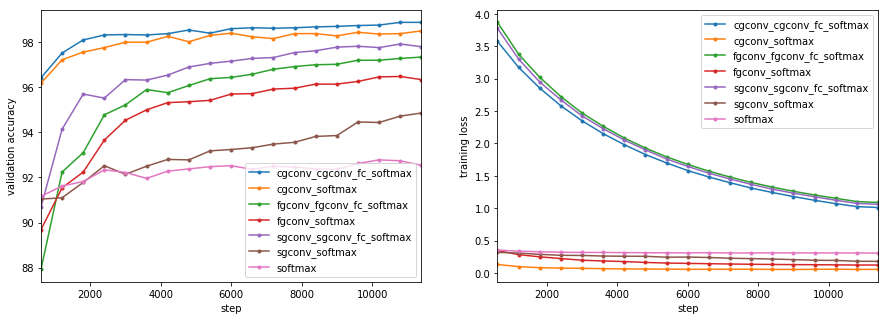

In [16]:
model_perf.show()

In [17]:
if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))